# Nível do Rio Ládario
O objetivo desta análise foi identificar os atributos que mais influenciam o nível do Rio Ládario e desenvolver um modelo de predição para auxiliar no monitoramento e tomada de decisões.

# Contexto
A previsão do nível do Rio Ládario é crucial para a gestão de recursos hídricos e prevenção de desastres, especialmente porque este rio desempenha um papel vital na região de Corumbá, localizada no Pantanal do Mato Grosso do Sul. O rio é fundamental tanto para o escoamento de matéria-prima quanto para o abastecimento de água das cidades próximas. Além disso, ele impacta diretamente a economia local, já que o transporte fluvial é essencial para a logística da região.

Para entender as variáveis que influenciam o nível do rio, foram utilizados dados climáticos e ambientais, como Temperatura Média, Umidade Máxima, e Precipitação Máxima, entre outros. A análise desses fatores visa fornecer insights para uma gestão mais eficiente do rio e preparar a região para possíveis variações críticas no nível da água.

# Análise de Correlação
A análise de correlação entre as variáveis revelou que:

- Temperatura Média tem uma correlação negativa moderada (-0.45) com o nível do rio, indicando que aumentos na temperatura podem estar relacionados a uma diminuição no nível.
- Umidade Máxima e Precipitação Máxima mostraram correlações mais fracas (-0.20 e -0.16, respectivamente), sugerindo que esses fatores, isoladamente, têm uma influência menos direta sobre o nível do rio.

# Realizando imports

In [3]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Carregando o Dataset e mostrando as primeiras linhas

In [4]:
# Load data from the CSV file
url = "https://raw.githubusercontent.com/senhorbento/MVP-Intelligent-Systems/refs/heads/main/databases/2023-ByDay.csv"
df = pd.read_csv(url, delimiter=';')

df.head()

,Data,Avg_Temperature,Max_Humidity,Max_Preciptation,Level
0,01/01/2023,29.41,88.5,0.0,0.32
1,02/01/2023,29.64,79.0,3.8,0.32
2,03/01/2023,25.09,91.5,5.4,0.38
3,04/01/2023,24.59,88.5,2.8,0.39
4,05/01/2023,26.51,91.0,0.0,0.42


# Selecionando as colunas numericas, criando a matriz de correlação e mostrando-a na tela.

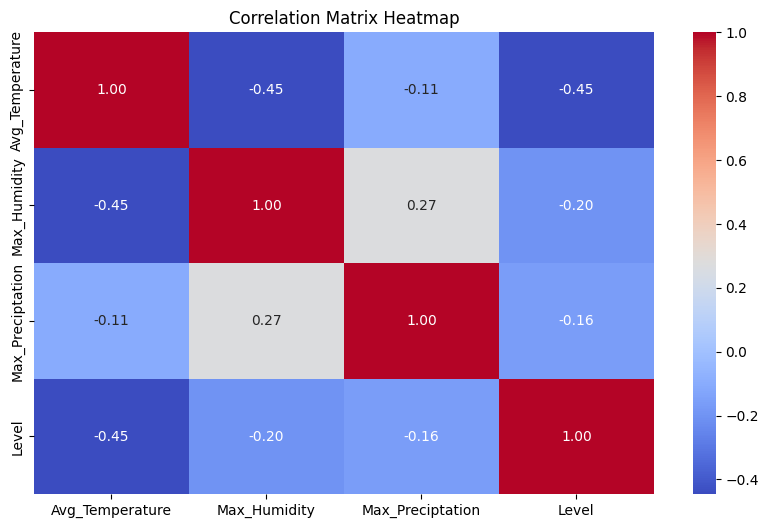

In [5]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


Através da matriz de correlação foi possível observar os seguintes pontos:

01. Avg_Temperature (Temperatura Média):
  - Tem uma correlação negativa moderada com o Level (Nível do Rio) (-0.45), sugerindo que, à medida que a temperatura aumenta, o nível do rio tende a diminuir.
  - Também apresenta correlação negativa com Max_Humidity (-0.45), ou seja, quando a temperatura sobe, a umidade tende a cair.
00. Max_Humidity (Máxima Umidade):
  - A correlação com o Level é ligeiramente negativa (-0.20), indicando uma leve tendência de o nível do rio diminuir com o aumento da umidade.
  - Tem uma correlação positiva moderada com Max_Precipitation (0.27), o que é esperado, já que maior umidade pode estar associada a mais precipitação.
00. Max_Precipitation (Máxima Precipitação):
  - Mostra uma correlação negativa leve com o Level (-0.16), o que pode ser contraintuitivo, mas pode significar que a precipitação máxima isolada não está diretamente ligada ao aumento do nível do rio, ou talvez os efeitos não sejam imediatos.
  - Correlaciona-se levemente com outras variáveis como Avg_Temperature (-0.11) e Max_Humidity (0.27).
00. Level (Nível do Rio):
Não possui correlações fortes com nenhuma das outras variáveis no gráfico, sendo a maior correlação negativa com Avg_Temperature (-0.45). Isso pode indicar que a temperatura é o fator mais influente nas variações de nível do rio entre as variáveis observadas.

# Separação em conjunto de treino e conjunto de teste com holdout

In [8]:
# Prepare the data
X = df[['Avg_Temperature', 'Max_Humidity', 'Max_Preciptation']]
y = df['Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

# Creating folds for cross-validation
num_particoes = 10  # number of folds for cross-validation
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7)


# Criação e avaliação de modelos

KNN: MSE 1.06 (0.22) - RMSE 1.03
CART: MSE 1.77 (0.36) - RMSE 1.33
LR: MSE 1.04 (0.16) - RMSE 1.02
Ridge: MSE 1.04 (0.16) - RMSE 1.02
Lasso: MSE 1.71 (0.15) - RMSE 1.31
SVM: MSE 0.91 (0.20) - RMSE 0.95


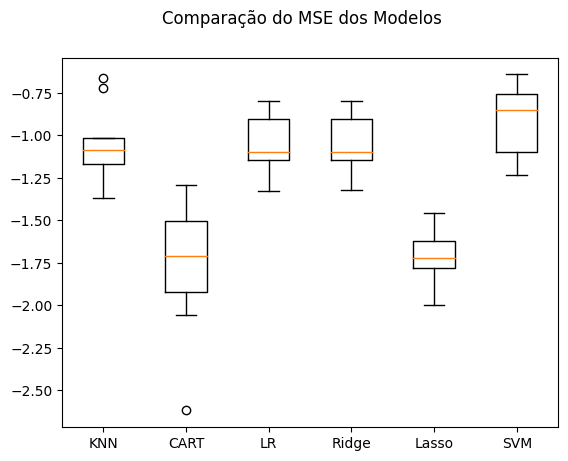

In [9]:
# Setting a global seed for reproducibility
np.random.seed(7)

# Lists to store models, results, and model names
models = []
results = []
names = []

# Preparing models
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('SVM', SVR()))

# Evaluating each model
for name, model in models:
    # Create a pipeline with standardization
    pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', model)])

    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)

    # Print MSE, standard deviation of MSE, and RMSE of the 10 cross-validation results
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    print(msg)

# Boxplot comparing the models
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



01. KNN (K-Nearest Neighbors):

  - Apresenta uma média mais alta (em torno de -1.0), indicando um MSE menor que os outros modelos.
  - Tem poucos outliers (valores fora do padrão), sugerindo um comportamento mais estável.

00. CART (Árvores de Decisão):
  - Exibe a maior variabilidade de MSE, com uma faixa ampla entre aproximadamente -2.5 e -1.0.
  - Há outliers visíveis tanto para MSE altos quanto baixos, o que pode indicar que o modelo é mais instável ou sensível aos dados.
  - A mediana do MSE é mais baixa, sugerindo que, em média, tem desempenho inferior a outros modelos.

00. LR (Regressão Linear) e Ridge:
  - Ambos os modelos têm distribuições de erro muito semelhantes, com uma faixa entre -1.75 e -1.0.
  - A mediana do MSE está aproximadamente no centro da distribuição, indicando um desempenho consistente, embora a faixa de MSE seja mais ampla do que em alguns outros modelos, como o KNN.

00. Lasso:
  - Tem uma distribuição compacta com uma mediana relativamente baixa (-1.75), indicando um MSE melhor que o de CART, mas pior que outros modelos.
  - A faixa de variabilidade é a menor entre os modelos, sugerindo que o Lasso é mais consistente.
  
00. SVM (Máquinas de Vetores de Suporte):
  - Possui uma variabilidade de MSE relativamente alta, com uma mediana perto de -1.0, mas apresenta outliers negativos que indicam uma performance menos estável.
  - O modelo tem uma faixa de erros ampla, o que pode significar que sua performance depende muito dos dados ou parâmetros escolhidos.

# Selecionando o melhor modelo de dados, treinando ele com todos os dados e validando o resultado final

In [7]:
# Selecting the best model (the one with the lowest MSE)
best_index = np.argmin([abs(cv.mean()) for cv in results])
best_model_name = names[best_index]
best_model = models[best_index][1]

# Training the best model with all training data
best_pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', best_model)])
best_pipeline.fit(X_train, y_train)

# Evaluation of the final model on the test data
y_pred = best_pipeline.predict(X_test)
print(f"Avaliação do modelo {best_model_name}:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")

Avaliação do modelo SVM:
RMSE: 0.9655762999090824
MAE: 0.75850752138701
R²: 0.5232024576923806
